## Create 3D PSF From 2D Radially averaged OTF

The input is a $no$ by $nr$ by $nz$ image which contains a radially averaged 3D OTF as a $nr$ by $nz$ 2D image for each order.

The output is a $nr$ by $nr$ by $nz$ image which contains the 3D PSF.

In [1]:
import mrc as Mrc
from scipy.fftpack import fftn, fftshift
import numpy as np
from tnia.plotting.projections import show_xyz_slice
from tnia.plotting.projections import show_xyz_slice_center 
import matplotlib.pyplot as plt
import os

## Define OTF Name and load the MRC file

In [2]:
#otf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\computed_OTF_folder\488nmLinOTF0.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\code\simrecon\test_data\otf.dv'
otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #2 Data (James System)\PSFs (best PSFs and examples of bad ones)\BEAD 2 - NON-AR 1.2W 25ms retake_20240503_170242 GOOD PSF!!\computed_OTF_folder\488nmLinOTF0.mrc'
#otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #1 Data (Ground truth baseline)\Ground truth OTFs System #1\488 OTF Bead 8_20190919_141256.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\cropped_MRC\from_debugger.mrc'
#otf_name = r'D:\Janelia\Data 2024-06-03\PSF-OTF used (Davids set of 4 wavelengths)\201909_19-20_best\488 OTF Bead 8_20190919_141256.mrc'

otf_mrc = Mrc.Mrc(otf_name)
otf_data = otf_mrc.data
print(otf_data.shape, otf_data.dtype)
otf_mrc
sxy, sxy, sz = otf_mrc.header.d[0], otf_mrc.header.d[1], otf_mrc.header.d[2]
print(sxy, sxy, sz)

(3, 81, 65) >c8
0.048076924 0.048076924 0.0


## Create PSF from OTF

Perform an inverse real FFT to get the PSF
 

(65, 160)


Text(0.5, 0.98, 'PSF from 488nmLinOTF0.mrc')

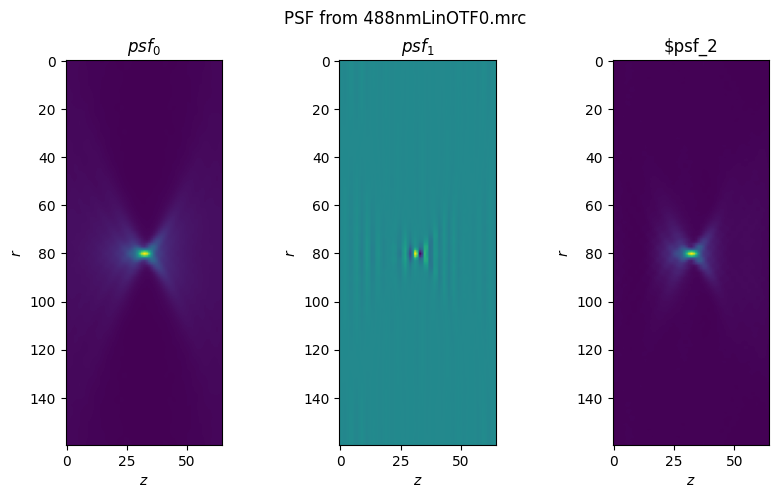

In [4]:
from tnia.plotting.plt_helper import imshow_multi2d
otf = [np.transpose(otf_data[i,:,:] ) for i in range(otf_data.shape[0])]
otf_abs = [np.abs(otf[i]) for i in range(otf_data.shape[0])]
real_shape = ( otf[0].shape[0], (otf[0].shape[1]-1)*2)
print(real_shape) 

psfs = [np.fft.irfftn(o, s=real_shape) for o in otf]
psfs_list = psfs
psfs = [np.transpose(psf) for psf in psfs]

psfs_shift = [fftshift(psf) for psf in psfs]
fig = imshow_multi2d(psfs_shift, ['$psf_0$', '$psf_1$', '$psf_2'], 1 ,3, xlabels = [f'$z$', '$z$', '$z$'], ylabels = [f'$r$', '$r$', '$r$'], height = 5)
fig.suptitle('PSF from '+os.path.basename(otf_name))

## Use interpolation to make 3D spatial PSF

First create the function that uses the interpolator to sample the 2d PSF in 3D

In [5]:
from scipy.interpolate import LinearNDInterpolator


def sample_2d_at_3d(image_2d, z, y, x, interp):
    x = np.abs(x - image_2d.shape[1]//2)
    y = np.abs(y - image_2d.shape[1]//2)
    r = np.sqrt(y**2 + x**2)
    index = image_2d.shape[1]//2 +r
    #r= int(r)
    if index<127:
        #val = image_2d[z, index]
        val = interp([z, index])
        return val
    else:
        return 0

Now for each PSF create the 3D PSDF

In [6]:
psfs_3d = []

#z_coords, y_coords, x_coords = np.meshgrid(z, y, x, indexing='ij')

for psf in psfs:
    psf = np.transpose(psf)
    psf = np.fft.ifftshift(psf)
    three_d = np.zeros((psf.shape[0], psf.shape[1], psf.shape[1]), dtype=np.float32)
    z = np.arange(three_d.shape[0])
    y = np.arange(three_d.shape[1])
    x = np.arange(three_d.shape[2])
    
    z_coords_, y_coords_ = np.meshgrid(z, y, indexing='ij')

    points = np.stack((z_coords_.flatten(), y_coords_.flatten()), axis=1)
    values = psf.flatten()
                  
    interp = LinearNDInterpolator(points, values)
    
    for i in range(three_d.shape[0]):
        for j in range(three_d.shape[1]):
            for k in range(three_d.shape[2]):
                three_d[i,j,k] = sample_2d_at_3d(psf, i, j, k, interp) 

    psfs_3d.append(three_d)


C:\Users\bnort\AppData\Local\Temp\ipykernel_22156\1455315768.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  three_d[i,j,k] = sample_2d_at_3d(psf, i, j, k, interp)


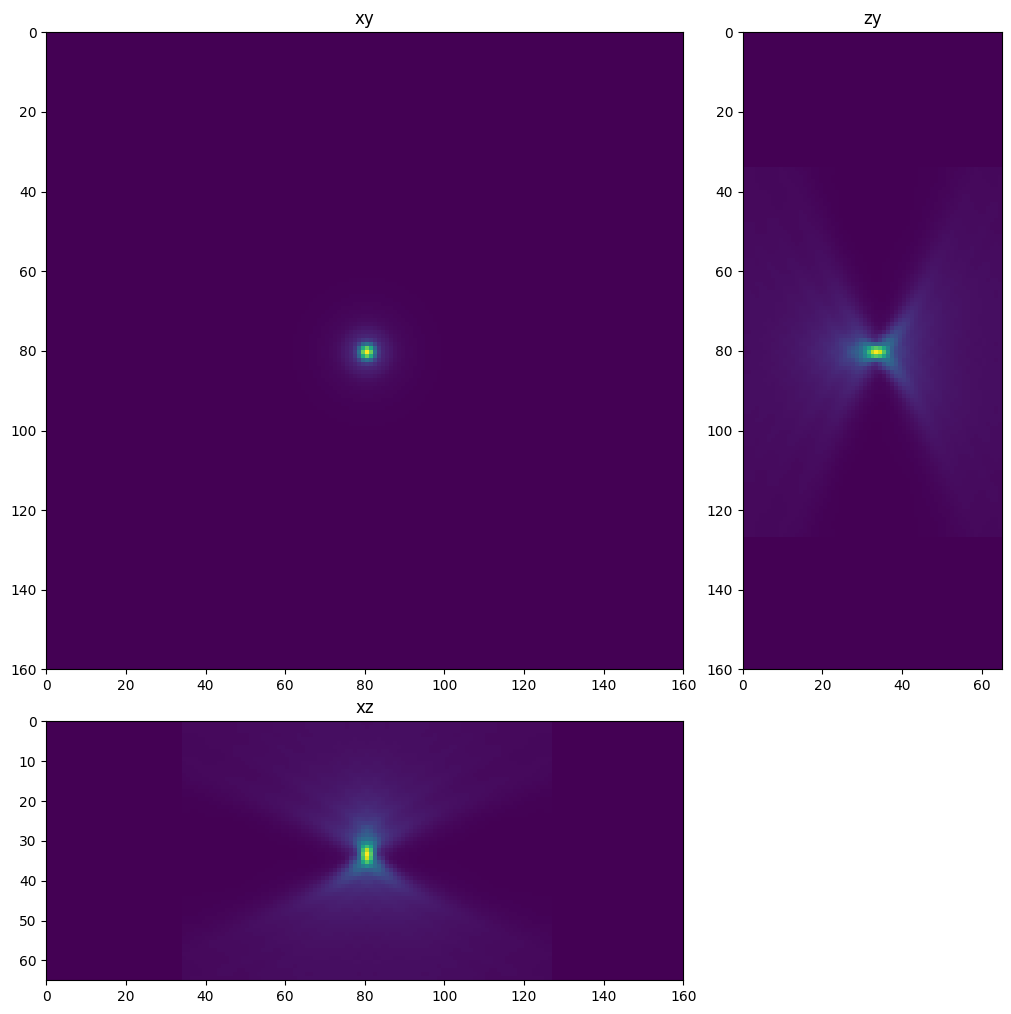

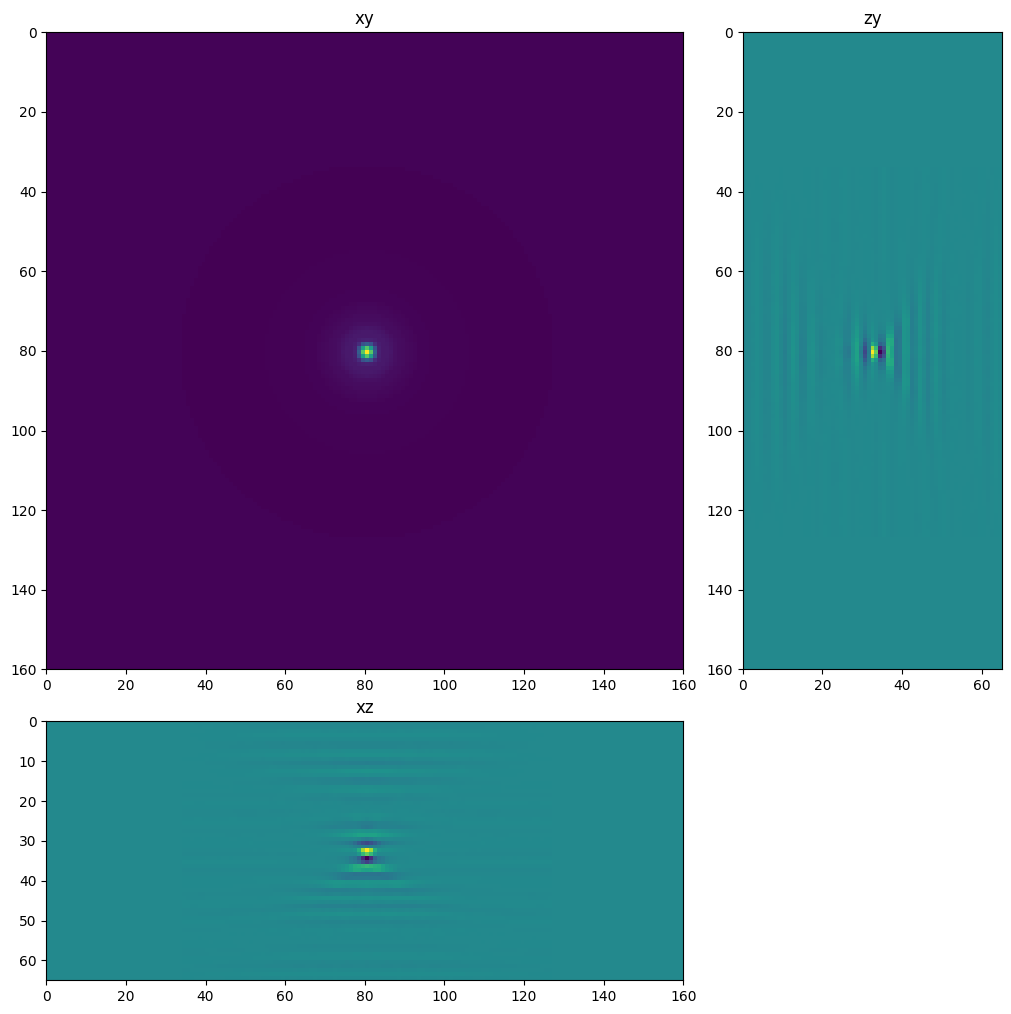

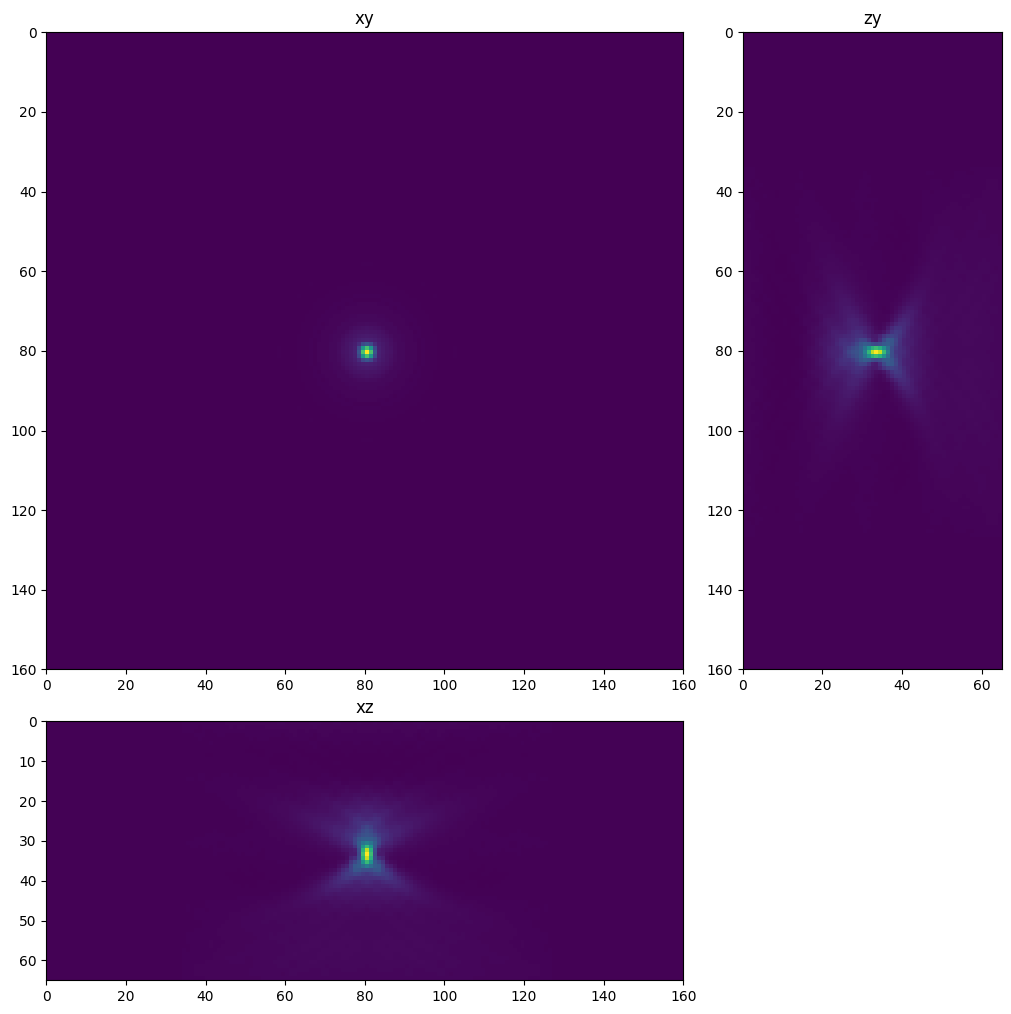

In [7]:
for psf_3d in psfs_3d:
    fig = show_xyz_slice_center(psf_3d)

## Save 3D PSFs

In [10]:
from skimage.io import imsave

psf_base_path = r'C:\Users\bnort\work\Janelia\psfs'
base_name = os.path.basename(otf_name).split('.')[0]
psf_path = os.path.join(psf_base_path, base_name)

if not os.path.exists(psf_path):
    os.makedirs(psf_path)

print(psf_base_path, base_name)
for i , psf_3d in enumerate(psfs_3d):
    psf_name = os.path.join(psf_path, 'psf_3d_'+str(i)+'.tif')
    imsave(psf_name, psf_3d)

C:\Users\bnort\work\Janelia\psfs 488nmLinOTF0


C:\Users\bnort\AppData\Local\Temp\ipykernel_22156\3407728070.py:13: UserWarning: C:\Users\bnort\work\Janelia\psfs\488nmLinOTF0\psf_3d_0.tif is a low contrast image
  imsave(psf_name, psf_3d)
C:\Users\bnort\AppData\Local\Temp\ipykernel_22156\3407728070.py:13: UserWarning: C:\Users\bnort\work\Janelia\psfs\488nmLinOTF0\psf_3d_1.tif is a low contrast image
  imsave(psf_name, psf_3d)
C:\Users\bnort\AppData\Local\Temp\ipykernel_22156\3407728070.py:13: UserWarning: C:\Users\bnort\work\Janelia\psfs\488nmLinOTF0\psf_3d_2.tif is a low contrast image
  imsave(psf_name, psf_3d)
